<a href="https://colab.research.google.com/github/tanpinray/ELEC0134-AMLS-CW/blob/main/Task_B_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import shutil
import random
import math
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from skimage.io import imread, imsave
from skimage.filters import gaussian
from skimage.exposure import equalize_adapthist
import imgaug.augmenters as iaa

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Sequential, Model

from sklearn import svm, metrics
# from keras import optimizers
# from keras.preprocessing.image import ImageDataGenerator
# from keras.preprocessing import image


In [ ]:
# For google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Train and Validation dataset

In [ ]:
# For google colab
train_path = '/content/drive/My Drive/dataset'
train_datapath = '/content/drive/My Drive/dataset/image'
new_train_path = os.path.join(train_path, 'image_classes')
df_train = pd.read_csv(os.path.join(train_path, 'label.csv'))

# # For offline use
# train_path = './dataset'
# train_datapath = './dataset/image'
# new_train_path = os.path.join(train_path, 'image_classes')
# df_train = pd.read_csv(os.path.join(train_path, 'label.csv'))

if os.path.exists(new_train_path):
    print('The directory with images sorted by classes already exists')
else:
  os.mkdir(new_train_path)
  for label in df_train['label'].unique():
    os.mkdir(os.path.join(new_train_path, label))
  
  for filename in df_train['file_name']:
    idx = df_train.index[df_train['file_name']==filename].item()
    if df_train.loc[idx, 'label'] == 'no_tumor':
      shutil.copy(os.path.join(train_datapath, filename), os.path.join(new_train_path, 'no_tumor'))
      print(df_train.loc[idx, 'label'])
    elif df_train.loc[idx, 'label'] =='glioma_tumor':
      shutil.copy(os.path.join(train_datapath, filename), os.path.join(new_train_path, 'glioma_tumor'))
      print(df_train.loc[idx, 'label'])
    elif df_train.loc[idx, 'label'] =='meningioma_tumor':
      shutil.copy(os.path.join(train_datapath, filename), os.path.join(new_train_path, 'meningioma_tumor'))
      print(df_train.loc[idx, 'label'])
    elif df_train.loc[idx, 'label'] =='pituitary_tumor':
      shutil.copy(os.path.join(train_datapath, filename), os.path.join(new_train_path, 'pituitary_tumor'))
      print(df_train.loc[idx, 'label'])
    

The directory with images sorted by classes already exists


In [ ]:
images = []
for filename in tqdm(df_train['file_name']):
    # obtain pixel data from the image after converting image to grayscale
    im = imread(os.path.join(train_datapath, filename))
    images.append(im)

# Index of images with no_tumor label
noTumor_idx = df_train.index[df_train['label'] == 'no_tumor'].tolist()
# Index of images with glioma_tumor label
glioma_idx = df_train.index[df_train['label'] == 'glioma_tumor'].tolist()
# Index of images with meningioma_tumor label
meningioma_idx = df_train.index[df_train['label'] == 'meningioma_tumor'].tolist()

# List of images with no_tumor label
images_noTumor = []
for idx in noTumor_idx:
    images_noTumor.append(images[idx])

# Choose random indexes of images with glioma_tumor label up to 1/4 of the total number
glioma_idx_sample = random.choices(glioma_idx, k=math.floor(len(glioma_idx)/4))
# List of images with glioma_tumor label
images_glioma = []
for idx in glioma_idx_sample:
    images_glioma.append(images[idx])

# Choose random indexes of images with meningioma_tumor label up to 1/4 of the total number
meningioma_idx_sample = random.choices(
    meningioma_idx, k=math.floor(len(meningioma_idx)/4))
# List of images with meningioma_tumor label
images_meningioma = []
for idx in meningioma_idx_sample:
    images_meningioma.append(images[idx])

# Data Augmentation
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # horizontal flips
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5)),
        iaa.Sharpen(alpha=(0.0, 1.0), lightness=(0.75, 2.0))
    ),
    iaa.Affine(
        rotate=(-180, 180),
        shear=(-10, 10)
    )
], random_order=True)

image_number=3000
# Double the no_tumor images
images_aug_noTumor = seq(images=images_noTumor)
no_tumor_path = os.path.join(new_train_path, 'no_tumor')
for image in tqdm(images_aug_noTumor):
    image_filename = f'IMAGE_{image_number}.jpg'
    imsave(os.path.join(no_tumor_path, image_filename), image)
    image_number += 1

# Increases the glioma_tumor images by 1.25
images_aug_glioma = seq(images=images_glioma)
glioma_tumor_path = os.path.join(new_train_path, 'glioma_tumor')
for image in tqdm(images_aug_glioma):
    image_filename = f'IMAGE_{image_number}.jpg'
    imsave(os.path.join(glioma_tumor_path, image_filename), image)
    image_number += 1

# Increases the meningioma_tumor images by 1.25
images_aug_meningioma = seq(images=images_meningioma)
meningioma_tumor_path = os.path.join(new_train_path, 'meningioma_tumor')
for image in tqdm(images_aug_meningioma):
    image_filename = f'IMAGE_{image_number}.jpg'
    imsave(os.path.join(meningioma_tumor_path, image_filename), image)
    image_number += 1

  0%|          | 0/3000 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
len(images_aug_noTumor)

454

# Test dataset

In [ ]:
# For google colab
test_path = '/content/drive/My Drive/test'
test_datapath = '/content/drive/My Drive/test/image'
new_test_path = os.path.join(test_path, 'image_classes')
df_test = pd.read_csv(os.path.join(test_path, 'label.csv'))

# # For offline use
# test_path = './test'
# test_datapath = './test/image'
# new_test_path = os.path.join(test_path, 'image_classes')
# df_test = pd.read_csv(os.path.join(test_path, 'label.csv'))

if os.path.exists(new_test_path):
    print('The directory with images sorted by classes already exists')
else:
  os.mkdir(new_test_path)
  for label in df_test['label'].unique():
    os.mkdir(os.path.join(new_test_path, label))
  
  for filename in df_test['file_name']:
    idx = df_test.index[df_test['file_name']==filename].item()
    if df_test.loc[idx, 'label'] == 'no_tumor':
      shutil.copy(os.path.join(test_datapath, filename), os.path.join(new_test_path, 'no_tumor'))
      print(df_test.loc[idx, 'label'])
    elif df_test.loc[idx, 'label'] =='glioma_tumor':
      shutil.copy(os.path.join(test_datapath, filename), os.path.join(new_test_path, 'glioma_tumor'))
      print(df_test.loc[idx, 'label'])
    elif df_test.loc[idx, 'label'] =='meningioma_tumor':
      shutil.copy(os.path.join(test_datapath, filename), os.path.join(new_test_path, 'meningioma_tumor'))
      print(df_test.loc[idx, 'label'])
    elif df_test.loc[idx, 'label'] =='pituitary_tumor':
      shutil.copy(os.path.join(test_datapath, filename), os.path.join(new_test_path, 'pituitary_tumor'))
      print(df_test.loc[idx, 'label'])
    

The directory with images sorted by classes already exists


In [ ]:
batch_size = 32
img_height = 299
img_width = 299

train_ds = tf.keras.utils.image_dataset_from_directory(
  new_train_path,
  labels='inferred', 
  label_mode='int',
  validation_split=0.3,
  subset="training",
  shuffle = True,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  new_train_path,
  labels='inferred', 
  label_mode='int',
  validation_split=0.3,
  subset="validation",
  shuffle = True,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  new_test_path,
  labels='inferred', 
  label_mode='int',
  shuffle = True,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3882 files belonging to 4 classes.
Using 2718 files for training.
Found 3882 files belonging to 4 classes.
Using 1164 files for validation.
Found 200 files belonging to 4 classes.


In [ ]:
# def gaussian_filtering(images_pixelData):
#     '''
#     Inputs
#         images_pixelData: Dataset of image pixel data.

#     Return
#        filtered: A list of HOG features for each image.
#     '''
#     filtered_images = []

#     for i in tqdm(range(len(images_pixelData))):
#         filtered_img = gaussian(images_pixelData[i], sigma=1, mode='nearest')

#         filtered_images.append(filtered_img)

#     return filtered_images

In [ ]:
# def hist_equalizing(images_pixelData):
#     '''
#     Inputs
#         images_pixelData: Dataset of image pixel data.

#     Return
#        filtered: A list of HOG features for each image.
#     '''
#     equalized_images = []

#     for i in tqdm(range(len(images_pixelData))):
#         equalized_img = equalize_adapthist(images_pixelData[i], clip_limit=0.03, nbins=256)

#         equalized_images.append(filtered_img)

#     return equalized_images

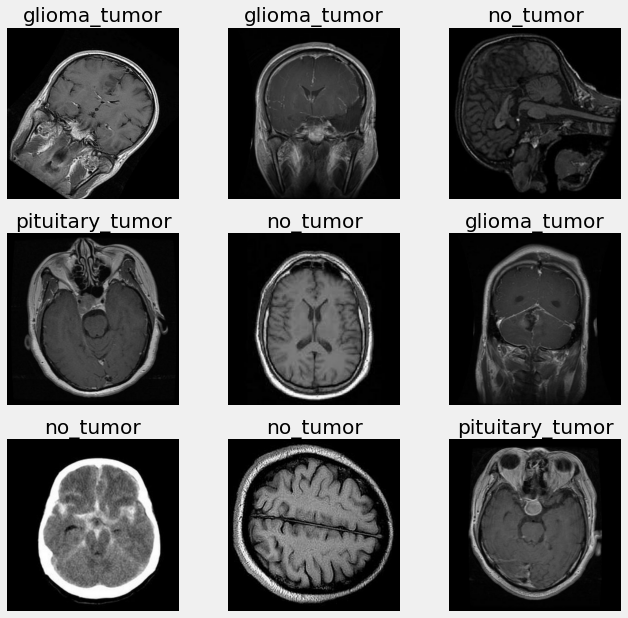

In [ ]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# Augment data by randomly flipping it horizontally, and rotations of 0.2
# data_augmentation = tf.keras.Sequential([
#   layers.RandomFlip('horizontal',
#                       input_shape=(img_height,
#                                   img_width,
#                                   3)),
#   layers.RandomRotation(factor=(-0.1, 0.1)),
# ])

# Convert the features to a single 1536-element vector per image
global_average_layer = layers.GlobalAveragePooling2D()
# Prediction layer
prediction_layer = layers.Dense(4, activation='softmax')

In [ ]:
base_model = tf.keras.applications.InceptionResNetV2(input_shape=(img_height, img_width, 3),
                                               include_top=False,
                                               weights='imagenet')

# image_batch, label_batch = next(iter(train_ds))
# feature_batch = base_model(image_batch)
# print(feature_batch.shape)

219070464/219055592 [==============================] - 2s 0us/step


In [ ]:
# Freeze the convolutional base before compile and train the model.
# Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. 
# InceptionResNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them
base_model.trainable = False
base_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                               

In [ ]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = tf.keras.applications.inception_resnet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = layers.Dense(4096, activation='relu')(x)
outputs = prediction_layer(x)
model = Model(inputs, outputs)

model.compile(optimizer=optimizers.Adadelta(learning_rate=1.0),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                      

In [ ]:
# First 10 epochs fitted without fine tuning
initial_epochs = 10

history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
34/85 [===========>..................] - ETA: 12:55 - loss: 2.5992 - accuracy: 0.4770

KeyboardInterrupt: ignored

In [ ]:
# model_path = os.path.join(path, 'saved_models')
# if os.path.exists(model_path):
#     print('The directory for saved models already exists')
# else:
#   os.mkdir(model_path)

# model.save(os.path.join(model_path, 'resnet50v2_tl'), save_format='h5')

In [ ]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  780


In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 775

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
model.compile(optimizer=optimizers.Adadelta(learning_rate=1.0),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 299, 299, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 299, 299, 3)      0         
 bda)                                                            
                                                                 
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_2   (None, 1536)             0         
 (GlobalAveragePooling2D)                                  

In [ ]:
len(model.trainable_variables)

8

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                    epochs=total_epochs,
                    initial_epoch=history.epoch[-1],
                    validation_data=val_ds)

Epoch 10/20
85/85 [==============================] - 120s 1s/step - loss: 0.6574 - accuracy: 0.7840 - val_loss: 0.6837 - val_accuracy: 0.7612
Epoch 11/20
85/85 [==============================] - 105s 1s/step - loss: 0.6537 - accuracy: 0.7851 - val_loss: 0.6801 - val_accuracy: 0.7612
Epoch 12/20
85/85 [==============================] - 105s 1s/step - loss: 0.6501 - accuracy: 0.7862 - val_loss: 0.6769 - val_accuracy: 0.7629
Epoch 13/20
85/85 [==============================] - 105s 1s/step - loss: 0.6466 - accuracy: 0.7899 - val_loss: 0.6739 - val_accuracy: 0.7620
Epoch 14/20
85/85 [==============================] - 105s 1s/step - loss: 0.6433 - accuracy: 0.7870 - val_loss: 0.6709 - val_accuracy: 0.7637
Epoch 15/20
85/85 [==============================] - 105s 1s/step - loss: 0.6401 - accuracy: 0.7903 - val_loss: 0.6680 - val_accuracy: 0.7603
Epoch 16/20
85/85 [==============================] - 105s 1s/step - loss: 0.6368 - accuracy: 0.7884 - val_loss: 0.6650 - val_accuracy: 0.7612
Epoch 

In [ ]:
# model.save(os.path.join(model_path, 'resnet50v2_tl_finetuned_all'), save_format='h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


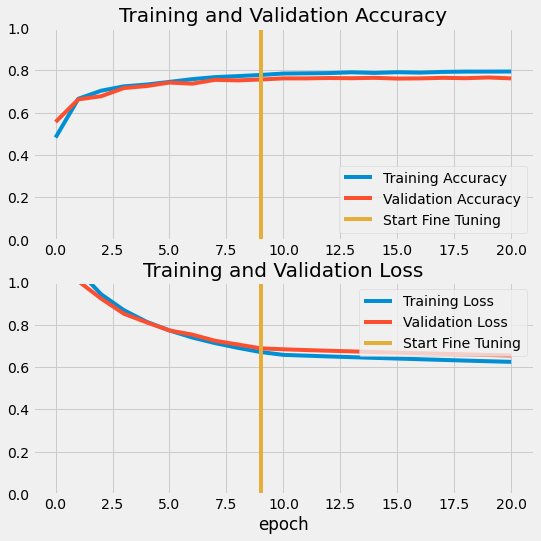

In [ ]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

<function matplotlib.pyplot.show>

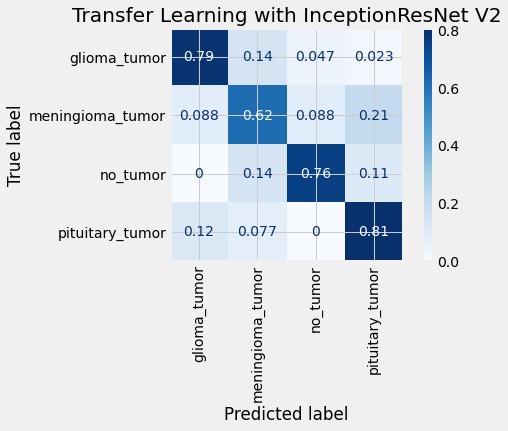

In [ ]:
predictions = np.array([])
labels =  np.array([])
for x, y in test_ds:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=-1)])
  labels = np.concatenate([labels, y.numpy()])
  # labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

disp = metrics.ConfusionMatrixDisplay.from_predictions(
        labels,
        predictions,
        display_labels = test_ds.class_names,
        xticks_rotation = 'vertical',
        cmap=plt.cm.Blues,
        normalize='true'
    )

disp.ax_.set_title('Transfer Learning with InceptionResNet V2')
plt.show

In [ ]:
# # AlexNet Implementation
# model = Sequential([
#     data_augmentation,
#     layers.Rescaling(1./255),
#     layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
#     layers.BatchNormalization(),
#     layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
#     layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
#     layers.BatchNormalization(),
#     layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
#     layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
#     layers.BatchNormalization(),
#     layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
#     layers.BatchNormalization(),
#     layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
#     layers.BatchNormalization(),
#     layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
#     layers.Flatten(),
#     layers.Dense(4096, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(4096, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(4, activation='softmax')
# ])
